In [1]:
cd ..

/home/wtaisner/PycharmProjects/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn as nn

from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *

/home/wtaisner/mambaforge/envs/reasonable-embeddings/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/wtaisner/mambaforge/envs/reasonable-embeddings/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/wtaisner/mambaforge/envs/reasonable-embeddings/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/wtaisner/mambaforge/envs/reasonable-embeddings/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.sm

In [3]:
class RelaxedEmbeddingLayer(nn.Module):
    def __init__(self, *, emb_size, n_concepts, n_roles):
        super().__init__()
        self.n_concepts = n_concepts
        self.n_roles = n_roles
        self.emb_size = emb_size
        self.top_concept = nn.Parameter(T.zeros((1, emb_size)))
        self.bot_concept = nn.Parameter(T.zeros((1, emb_size)))
        self.concepts = nn.Parameter(T.zeros((n_concepts, emb_size)))
        self.roles = nn.ModuleList([nn.Linear(emb_size, emb_size) for _ in range(n_roles)])
        self.and_nn = nn.Linear(2*emb_size + emb_size**2, emb_size)
        self.not_nn = nn.Linear(emb_size, emb_size)
        for x in [self.concepts, self.top_concept, self.bot_concept]:
            nn.init.xavier_normal_(x)
        
    @classmethod
    def from_onto(cls, onto, *args, **kwargs):
        return cls(n_concepts=onto.n_concepts, n_roles=onto.n_roles, *args, **kwargs)
    
class RelaxedReasonerHead(nn.Module):
    def __init__(self, *, emb_size, hidden_size):
        super().__init__()
        self.hidden_size, self.emb_size = hidden_size, emb_size
        self.sub_nn = nn.Sequential(
            nn.Linear(2*emb_size + emb_size**2, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, 1),
        )
        
        self.rvnn_act = lambda x: x
            
    def encode(self, axiom, embeddings):
        def rec(expr):
            if expr == TOP:
                return self.rvnn_act(embeddings.top_concept[0])
            elif expr == BOT:
                return self.rvnn_act(embeddings.bot_concept[0])
            elif isinstance(expr, int):
                return self.rvnn_act(embeddings.concepts[expr])
            elif expr[0] == SUB:
                c = rec(expr[1])
                d = rec(expr[2])
                cxd = T.outer(c, d).view(-1)
                return self.sub_nn(T.cat((c, d, cxd)))
            elif expr[0] == AND:
                c = rec(expr[1])
                d = rec(expr[2])
                return self.rvnn_act(embeddings.and_nn(im(c, d)))
            elif expr[0] == ANY:
                c = rec(expr[2])
                r = embeddings.roles[expr[1]]
                return self.rvnn_act(r(c))
            elif expr[0] == NOT:
                c = rec(expr[1])
                return self.rvnn_act(embeddings.not_nn(c))
            assert False, f'Unsupported expression {expr}. Did you convert it to core form?'
        return rec(axiom)
    
    def classify_batch(self, axioms, embeddings):
        return T.vstack([self.encode(axiom, emb) for axiom, emb in zip(axioms, embeddings)])
    
    def classify(self, axiom, emb):
        return self.classify_batch([axiom], [emb])[0].item()
    
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 32
hidden_size = 16
lr_reasoner = 0.0001
lr_encoder = 0.0002
lr_encoder_test = lr_encoder
epoch_count = 10
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = RelaxedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [RelaxedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

train_logger = train(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size)

created reasoner with 17441 parameters
created 40 encoders with 42848 parameters each
train epoch 00/10 | batch 2001/2000 | loss 0.6344 | val loss 0.6333 | acc 0.7869 | f1 0.0000 | prec 0.0000 | recall 0.0000 | roc auc 0.5013 | pr auc 0.2219 | elapsed 13.47s
train epoch 01/10 | batch 2001/2000 | loss 0.5530 | val loss 0.4768 | acc 0.8002 | f1 0.1176 | prec 1.0000 | recall 0.0625 | roc auc 0.6970 | pr auc 0.4624 | elapsed 52.00s
train epoch 02/10 | batch 2001/2000 | loss 0.3799 | val loss 0.3660 | acc 0.8612 | f1 0.5598 | prec 0.8636 | recall 0.4141 | roc auc 0.8289 | pr auc 0.7014 | elapsed 51.00s
train epoch 03/10 | batch 2001/2000 | loss 0.2402 | val loss 0.3353 | acc 0.8837 | f1 0.6732 | prec 0.8389 | recall 0.5622 | roc auc 0.8604 | pr auc 0.7618 | elapsed 51.83s
train epoch 04/10 | batch 2001/2000 | loss 0.1601 | val loss 0.3413 | acc 0.8926 | f1 0.7145 | prec 0.8244 | recall 0.6305 | roc auc 0.8734 | pr auc 0.7882 | elapsed 51.63s
train epoch 05/10 | batch 2001/2000 | loss 0.1069

In [4]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = RelaxedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [RelaxedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner


train epoch 00/10 | batch 1251/1250 | loss 1.1901 | val loss 1.1901 | acc 0.5757 | f1 0.2604 | prec 0.2097 | recall 0.3436 | roc auc 0.4920 | pr auc 0.2154 | elapsed 11.53s
train epoch 01/10 | batch 1251/1250 | loss 0.7575 | val loss 0.5117 | acc 0.8008 | f1 0.5138 | prec 0.5472 | recall 0.4842 | roc auc 0.7748 | pr auc 0.4996 | elapsed 30.50s
train epoch 02/10 | batch 1251/1250 | loss 0.4627 | val loss 0.3311 | acc 0.8806 | f1 0.7036 | prec 0.7640 | recall 0.6520 | roc auc 0.8901 | pr auc 0.7509 | elapsed 30.60s
train epoch 03/10 | batch 1251/1250 | loss 0.3070 | val loss 0.2170 | acc 0.9310 | f1 0.8302 | prec 0.8928 | recall 0.7758 | roc auc 0.9500 | pr auc 0.8916 | elapsed 33.31s
train epoch 04/10 | batch 1251/1250 | loss 0.2069 | val loss 0.1462 | acc 0.9584 | f1 0.8988 | prec 0.9521 | recall 0.8512 | roc auc 0.9780 | pr auc 0.9483 | elapsed 32.83s
train epoch 05/10 | batch 1251/1250 | loss 0.1433 | val loss 0.1022 | acc 0.9735 | f1 0.9367 | prec 0.9757 | recall 0.9006 | roc auc 0.

In [5]:
with T.no_grad():
    idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240321T103941


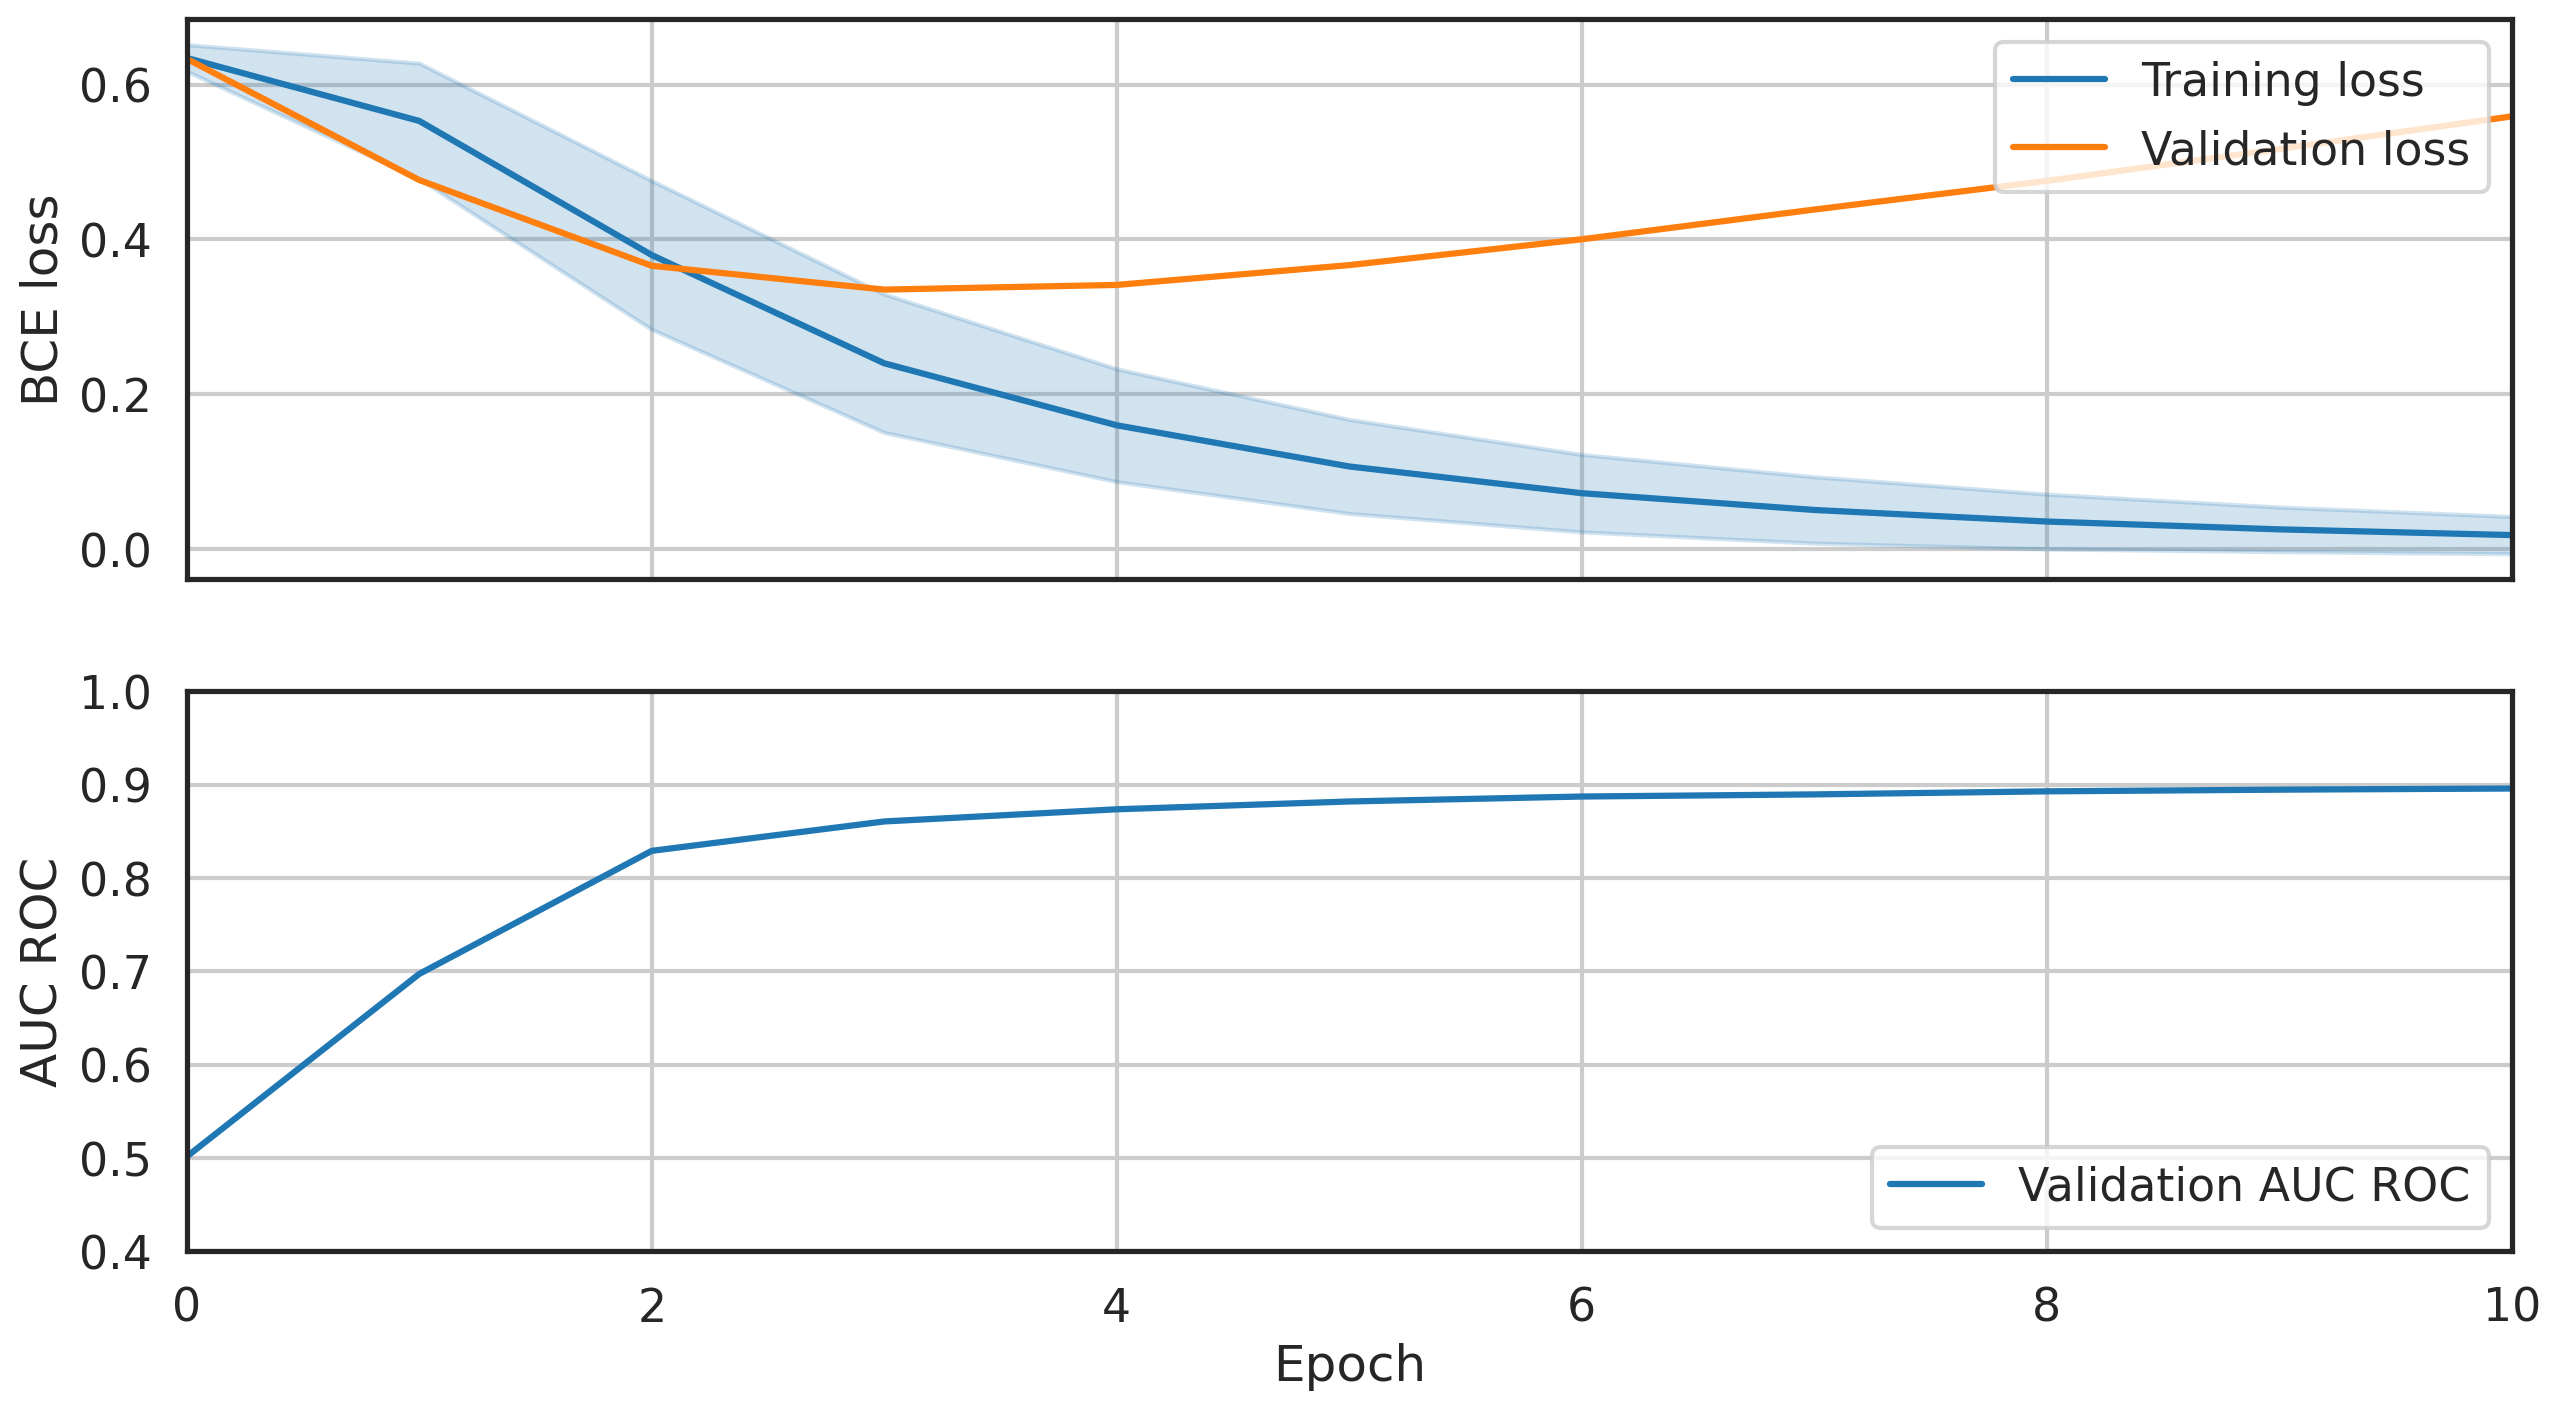

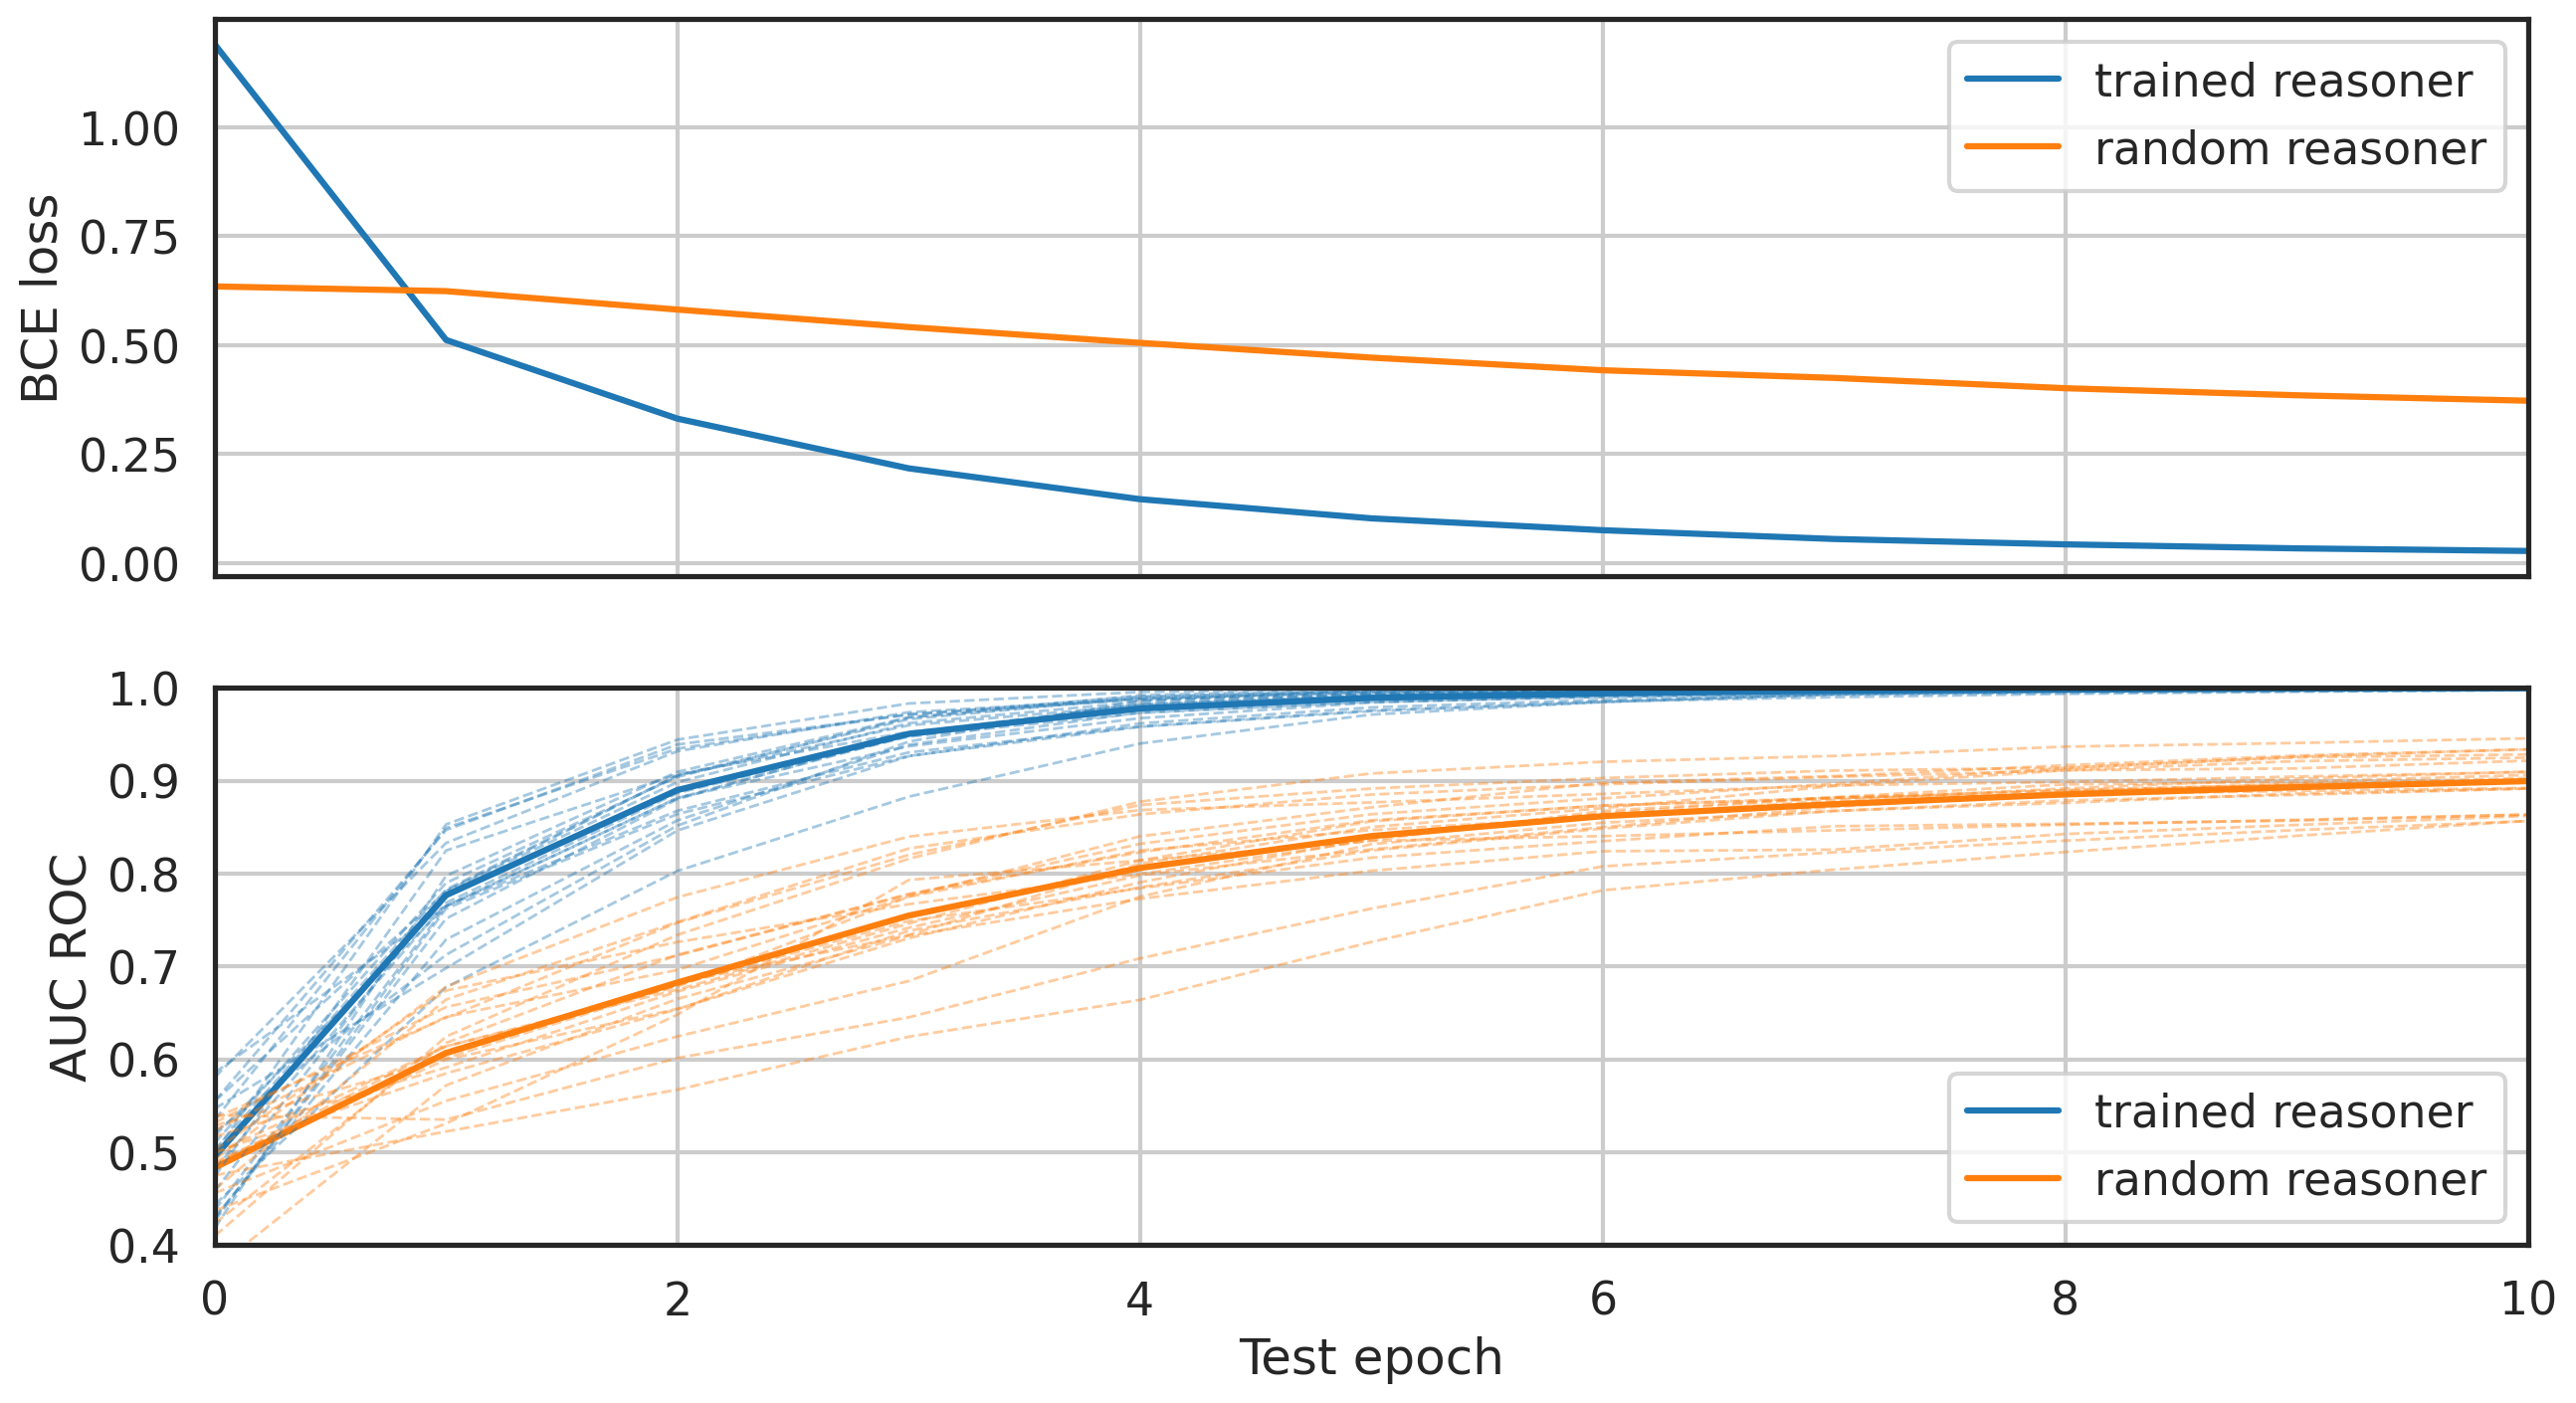

             mean       std     micro
acc      0.992700  0.005040  0.992700
prec     0.993589  0.009544  0.993656
recall   0.972779  0.016920  0.972631
f1       0.983008  0.011172  0.983031
auc_roc  0.999383  0.000791  0.999483
auc_pr   0.997849  0.002736  0.998111
             mean       std     micro
acc      0.884075  0.017382  0.884075
prec     0.991660  0.006990  0.991762
recall   0.468644  0.058749  0.470676
f1       0.634325  0.056315  0.638384
auc_roc  0.899454  0.027644  0.901010
auc_pr   0.834659  0.044724  0.837094


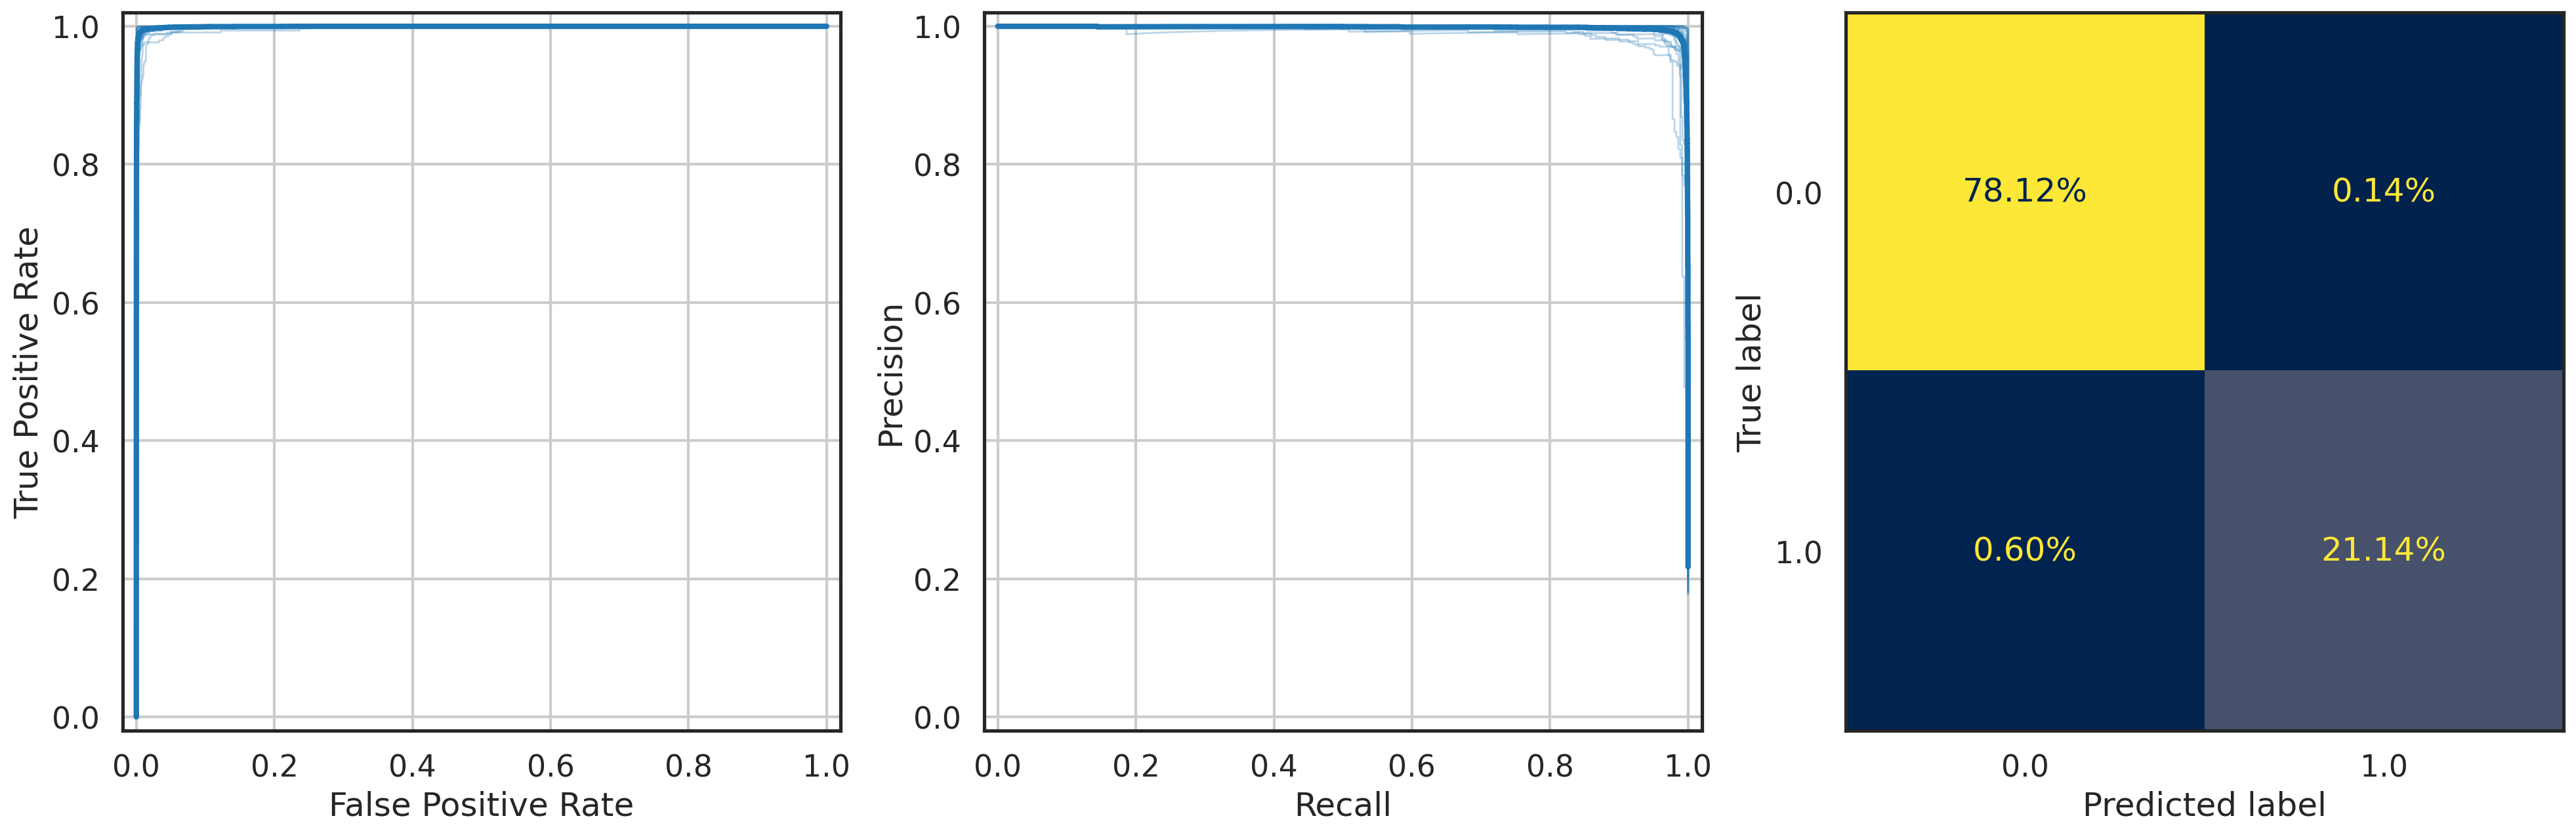

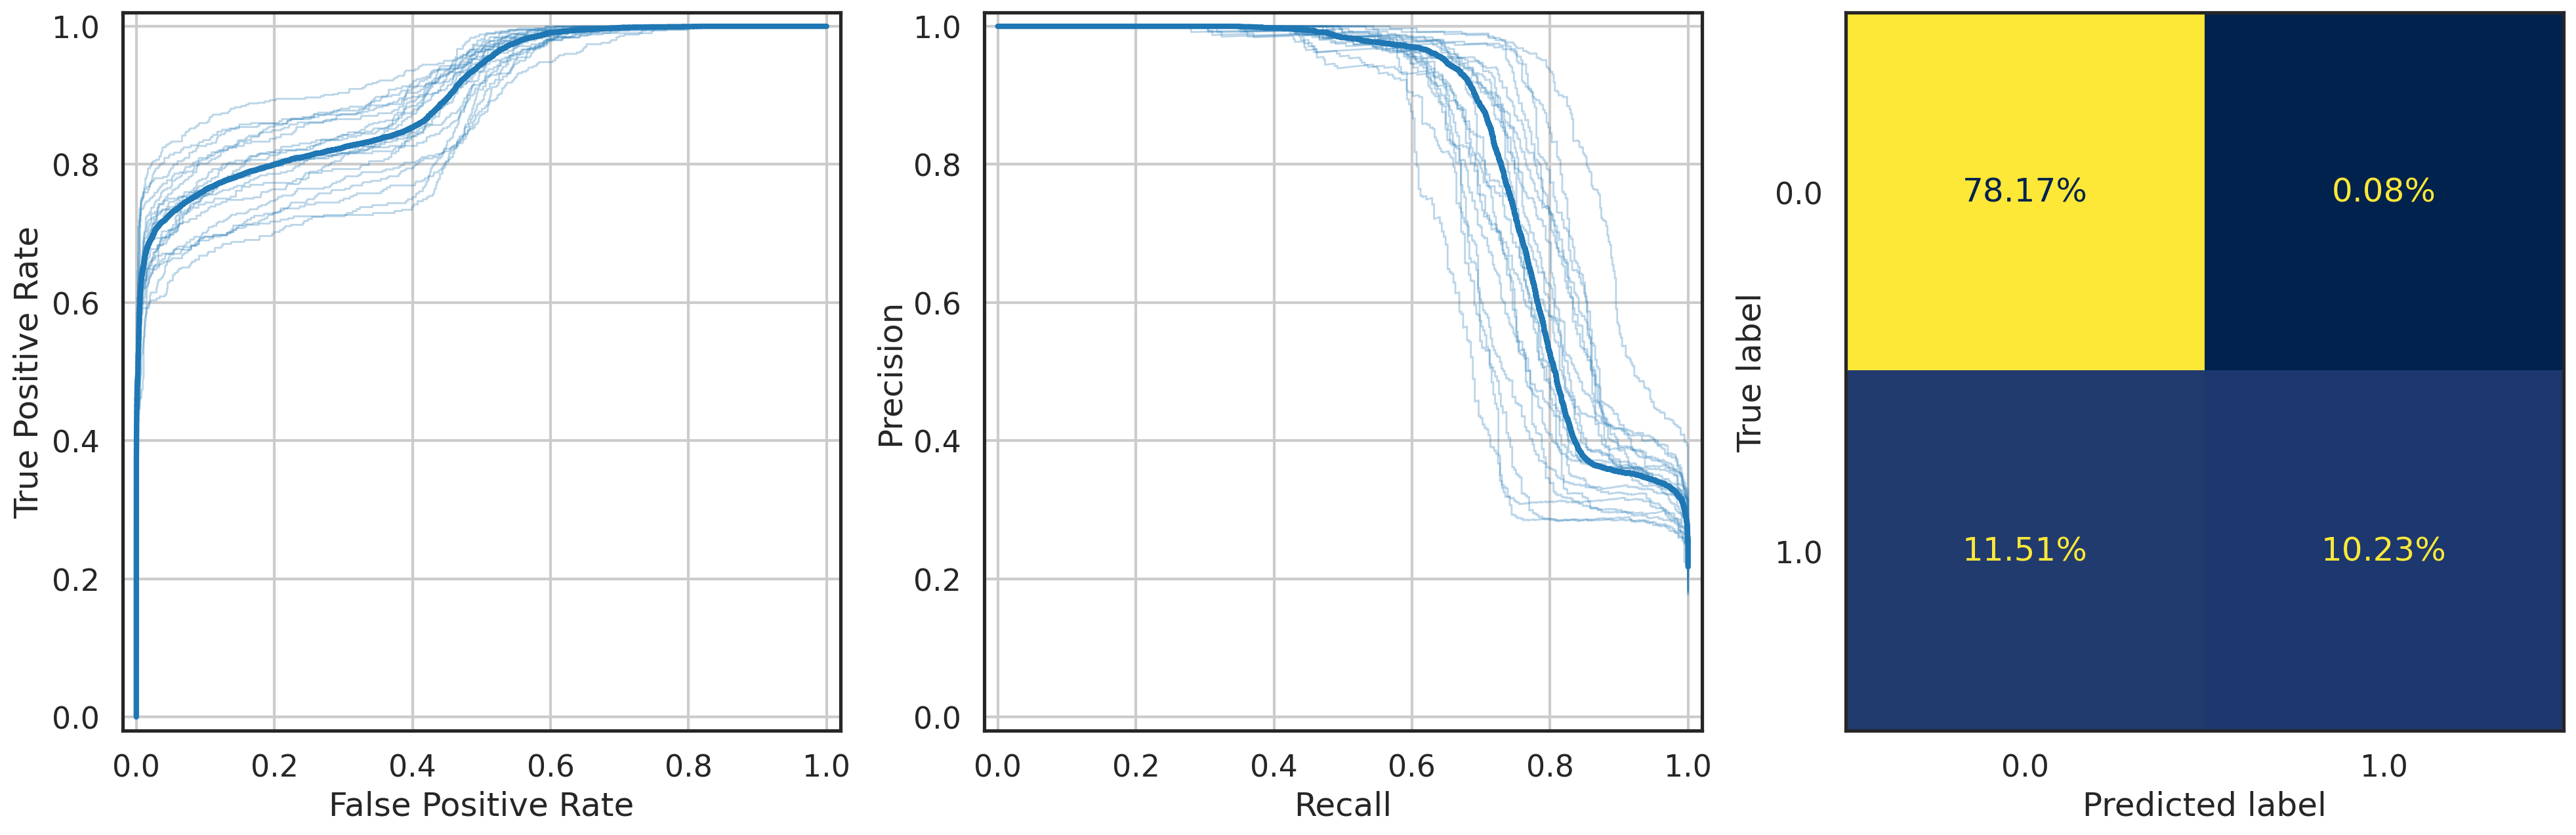

In [6]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good, Y_te_rand=Y_te_rand))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print(report(test_onto, y_te, np.array(Y_te_good), idx_te, save=base+'/%-trained'))
print(report(test_onto, y_te, np.array(Y_te_rand), idx_te, save=base+'/%-random'))